In [1]:
import sys, os, glob
import torch
import cv2
from models.SSECEncoders import VGGEncoder
from train_SSEC import load_models, get_dataloaders

import numpy as np
import matplotlib.pyplot as plt
model_weights_path = 'model_weights/SSECEncodersLowTemp/'

train_dl, val_dl, test_dl = get_dataloaders(10,10,10,0,0,0,True,'/scratch/shared/beegfs/rhydian/UKBiobank',False)
dxa_model, mri_model, val_stats, epochs = load_models(VGGEncoder,128,True, model_weights_path,False)

Trying to load from model_weights/SSECEncodersLowTemp/
==> Resuming model trained for 225 epochs...


/users/rhydian/anaconda3/envs/torch_env/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
import torch.nn.functional as F

dxa_model.eval()
mri_model.eval()
for idx, sample in enumerate(val_dl):
    mri_img = sample['mri_img']
    dxa_img = sample['dxa_img']

    with torch.no_grad():
        
        
        dxa_ses = dxa_model(dxa_img).cpu()
        mri_ses = mri_model(mri_img).cpu()
        mri_ses = F.normalize(mri_ses,dim=1)
        dxa_ses = F.normalize(dxa_ses,dim=1)
        mri_b, mri_c, mri_h, mri_w = mri_ses.size()
        conv_ses = (F.conv2d(dxa_ses, mri_ses)/(mri_h*mri_w))
    break
    
print(sample.keys())

dict_keys(['dxa_img', 'mri_img'])


In [3]:
def get_4d_corr(se1, se2):
    b1, c1, h1, w1 = se1.size()
    b2, c2, h2, w2 = se2.size()
    corr = torch.bmm(se1.permute(0,2,3,1).view(b1,h1*w1,c1),se2.view(b2, c2, h2*w2))
    corr = corr.view(b1, h1, w1, h2, w2)
    return corr

def resample_point(src_img, tgt_img, point):
    hs, ws = src_img.size()
    ht, wt = tgt_img.size()
    resampled_point = [None, None]
    resampled_point[0] = np.round(point[0]*ht/hs).astype(np.int)
    resampled_point[1] = np.round(point[1]*wt/ws).astype(np.int)
    return resampled_point

def correlate_point(corr, pt=(30,30),tgt='a', softmax=True):
    assert tgt in ['a','b']
    if tgt == 'a':
        corr_point_map = corr[:,pt[0],pt[1],:,:]
    else:
        corr_point_map = corr[:,:,:,pt[0],pt[1]]
    temperature = 0.1
    if softmax:
        b, h, w = corr_point_map.size()
        corr_point_map = F.softmax(corr_point_map.view(b,h*w)/temperature,dim=1).view(b,h,w)
    
    return corr_point_map

def get_most_discriminative_points(points, corr_map, src_img, tgt_img, num_points=80):
    scored_points = []
    for idx, point in enumerate(points):
        ses_point = resample_point(src_img[0],corr_map[:,:,0,0], point)
        # get correlation map
        corr_point_map = correlate_point(corr_map[None], ses_point, tgt='a', softmax=True)
        # find argmax of correlation map
        tgt_ses_pt = [int(corr_point_map[0].argmax() // corr_point_map.shape[2]), int(corr_point_map[0].argmax() % corr_point_map.shape[2])]
        
        # get correlation at this point
        score = corr_point_map.max()
        # resample argmax correlation point
        corres_point = resample_point(corr_map[0,0,:,:], tgt_img[0], tgt_ses_pt)
        # save to array
        scored_points.append([point, corres_point, corr_point_map.max(), ses_point])
        
    # sort and choose most discriminative point
    scored_points.sort(key=lambda x: -x[2])
    return [x[0] for x in scored_points[:num_points]],[x[1] for x in scored_points[:num_points]], [x[2] for x in scored_points[:num_points]]

def get_cyclic_most_discriminative_points(points, corr_map, src_img, tgt_img, num_points=80):
    scored_points = []
    for idx, point in enumerate(points):
        ses_point = resample_point(src_img[0],corr_map[:,:,0,0], point)
        # get correlation map
        corr_point_map = correlate_point(corr_map[None], ses_point, tgt='a', softmax=True)
        # find argmax of correlation map
        tgt_ses_pt = [int(corr_point_map[0].argmax() // corr_point_map.shape[2]), int(corr_point_map[0].argmax() % corr_point_map.shape[2])]
        
        other_corr_point_map = correlate_point(corr_map[None], tgt_ses_pt, tgt='b', softmax=True)
        # get correlation at this point
        score = corr_point_map.max()*other_corr_point_map.max()
        # resample argmax correlation point
        corres_point = resample_point(corr_map[0,0,:,:], tgt_img[0], tgt_ses_pt)
        # save to array
        scored_points.append([point, corres_point, corr_point_map.max(), ses_point])
        
    # sort and choose most discriminative point
    scored_points.sort(key=lambda x: -x[2])
    return [x[0] for x in scored_points[:num_points]],[x[1] for x in scored_points[:num_points]], [x[2] for x in scored_points[:num_points]]


def RANSAC(src_pts, tgt_pts, tol=5):
    src_pts = np.array(src_pts)[:,np.newaxis]
    tgt_pts = np.array(tgt_pts)[:,np.newaxis]
    
    M, mask = cv2.findHomography(src_pts, tgt_pts, cv2.RANSAC,tol)
    src_inliers = np.array([src_point[0] for src_idx, src_point in enumerate(src_pts) if mask.ravel()[src_idx]])
    tgt_inliers = np.array([tgt_point[0] for tgt_idx, tgt_point in enumerate(tgt_pts) if mask.ravel()[tgt_idx]])
    return src_inliers, tgt_inliers,M

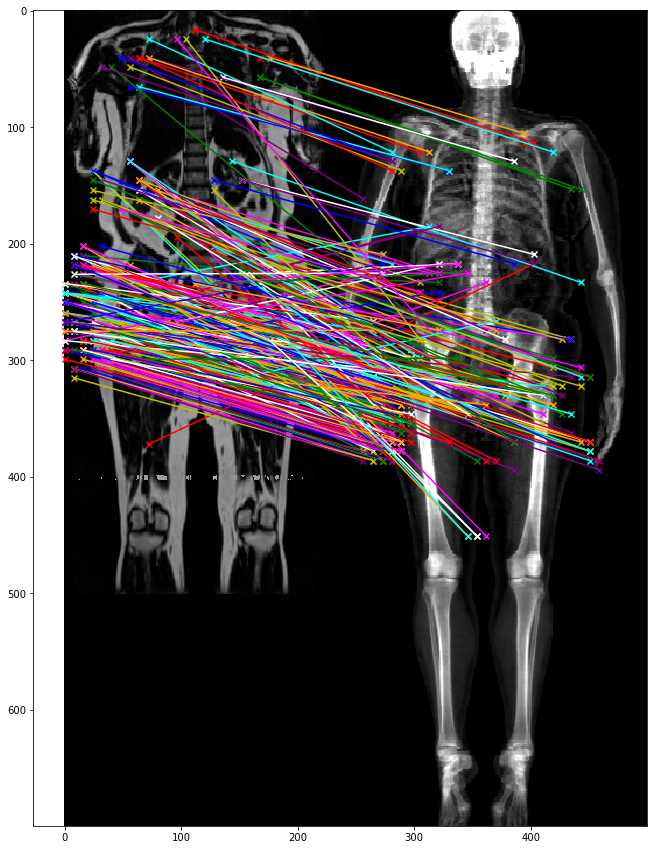

In [4]:
from gen_utils import *
def unravel_index(
    indices: torch.LongTensor,
    shape: torch.Size,
) -> torch.LongTensor:
    r"""Converts flat indices into unraveled coordinates in a target shape.

    This is a `torch` implementation of `numpy.unravel_index`.

    Args:
        indices: A tensor of indices, (*, N).
        shape: The targeted shape, (D,).

    Returns:
        unravel coordinates, (*, N, D).
    """

    shape = torch.tensor(shape)
    indices = indices % shape.prod()  # prevent out-of-bounds indices

    coord = torch.zeros(indices.size() + shape.size(), dtype=int)

    for i, dim in enumerate(reversed(shape)):
        coord[..., i] = indices % dim
        indices = indices // dim

    return coord.flip(-1)

def softmax_corr4d(corr4d,temp=0.1):
    b, h1, w1, h2, w2 = corr4d.size()
    corr4d = corr4d.view(b,h1*w1,h2*w2)
    exp_corr4d = torch.exp(corr4d/temp)
    sums = exp_corr4d.sum(dim=-2,keepdim=True) + exp_corr4d.sum(dim=-1,keepdim=True)
    return (exp_corr4d/sums).view(b,h1,w1,h2,w2)
    
    
def get_highly_correlated_points(corr4d, num_points):
    assert corr4d.shape[0], "should be single tensor with batch dimension (ie. 5d)"
    sftmax_corr4d = softmax_corr4d(corr4d)
    corr4d_shape = corr4d.shape
    b, h1, w1, h2, w2 = corr4d.size()
    scores, indicies = torch.topk(sftmax_corr4d.flatten(),num_points)
    unravelled_indicies = unravel_index(indicies,corr4d_shape)
    img1_pts = unravelled_indicies[:,1:3]
    img2_pts = unravelled_indicies[:,3:]
    return scores, img1_pts, img2_pts

src_img = mri_img;
src_ses = mri_ses
tgt_img = dxa_img
tgt_ses = dxa_ses
src_idx = 7
tgt_idx = 7
TOLERANCE=5

# src_ses = F.interpolate(src_ses, scale_factor=1.5,mode='bicubic')
# tgt_ses = F.interpolate(tgt_ses, scale_factor=1.5,mode='bicubic')

corr4d = get_4d_corr(src_ses, tgt_ses)[0][None]
correlations, src_pts, tgt_pts = get_highly_correlated_points(corr4d, 300)

# plt.subplot(121)
# plt.imshow(F.interpolate(src_img, src_ses.shape[-2:])[0,0])
# plt.subplot(122)
# plt.imshow(F.interpolate(tgt_img, tgt_ses.shape[-2:])[0,0])
# for idx in range(src_pts.shape[0]):
#     pt = src_pts[idx]
#     other_pt = tgt_pts[idx]
#     plt.subplot(121)
#     plt.scatter(pt[1],pt[0])
#     plt.subplot(122)
#     plt.scatter(other_pt[1],other_pt[0])
#     plt.scatter(*pt+src_ses.shape[-2])
src_pts = [resample_point(src_ses[0,0],src_img[0,0],pt.tolist()) for pt in src_pts]
tgt_pts = [resample_point(tgt_ses[0,0],tgt_img[0,0],pt.tolist()) for pt in tgt_pts]

if src_img.shape[-2] < tgt_img.shape[-2]:
    show_src_img = np.concatenate([src_img[src_idx,0], np.zeros((tgt_img.shape[-2]-src_img.shape[-2],src_img.shape[-1]))])
    show_tgt_img = tgt_img[tgt_idx,0]
elif src_img.shape[-2] > tgt_img.shape[-2]:
    show_tgt_img = np.concatenate([tgt_img[tgt_idx,0], np.zeros((src_img.shape[-2]-tgt_img.shape[-2],tgt_img.shape[-1]))])
    show_src_img = src_img[src_idx,0]
else:
    show_tgt_img = tgt_img[tgt_idx,0]
    show_src_img = src_img[src_idx,0]
plt.figure(figsize=(15,15))

plt.imshow(grayscale(np.concatenate([show_src_img,show_tgt_img],axis=1)))
colors=['r','g','y','b','cyan','orange','purple','white','magenta']
for idx, point in enumerate(src_pts):
    plt.scatter(point[1],point[0],color=colors[idx%colors.__len__()],marker='x')
    match_point = tgt_pts[idx]
    plt.scatter(match_point[1]+src_img.shape[-1],match_point[0],marker='x',color=colors[idx%colors.__len__()])
    plt.plot([match_point[1]+src_img.shape[-1],point[1]],
             [match_point[0],point[0]],color=colors[idx%colors.__len__()])


# MRI to DXA

/users/rhydian/anaconda3/envs/torch_env/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


torch.Size([10, 2, 501, 224])


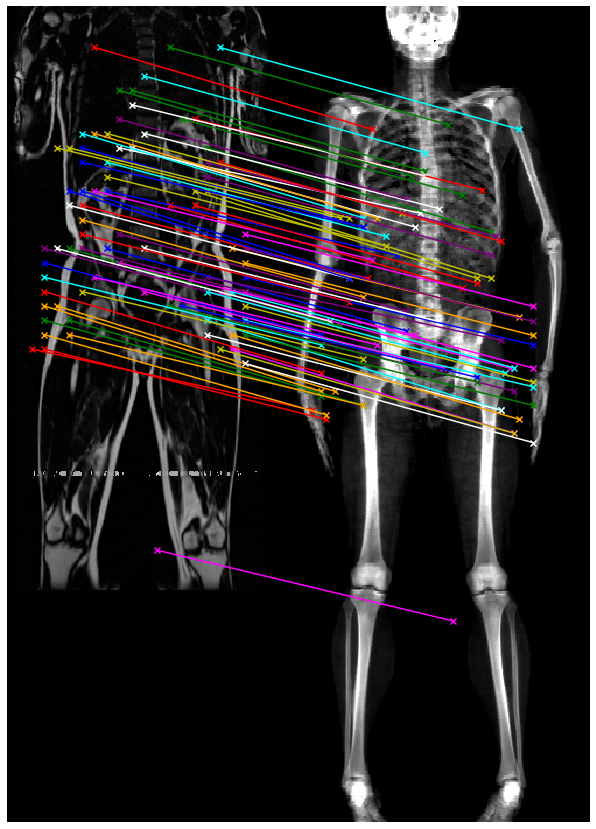

In [7]:
from gen_utils import *

src_img = mri_img; src_ses = mri_ses
tgt_img = dxa_img; tgt_ses = dxa_ses
src_idx = 3
tgt_idx = 3
TOLERANCE=3
USE_RANSAC=True
UPSAMPLE_FACTOR=2
USE_CYCLIC=True
save_file_name = f'images/keypoint_transfer/mri_to_dxa/example_{str(src_idx).zfill(3)}_{str(tgt_idx).zfill(3)}'

if UPSAMPLE_FACTOR != 1:
    src_ses = F.interpolate(src_ses, scale_factor=UPSAMPLE_FACTOR,mode='bicubic')
    tgt_ses = F.interpolate(tgt_ses, scale_factor=UPSAMPLE_FACTOR,mode='bicubic')
corr4d = get_4d_corr(src_ses[src_idx][None], tgt_ses[tgt_idx][None])
print(src_img.shape)
# get mesh in source_image image
X,Y =np.meshgrid(np.linspace(10,src_img.shape[-2]-10,40),np.linspace(10,src_img.shape[-1]-10,20))
points = np.stack((X.reshape(-1),Y.reshape(-1))).transpose()
points = points[np.random.permutation(np.arange(points.shape[0]))]

#     find most discriminative from meshgrid

if USE_CYCLIC:
    src_discrim_points, tgt_match_points, correlations = get_cyclic_most_discriminative_points(points,corr4d[0],
                                                                                        src_img[src_idx], 
                                                                                        tgt_img[tgt_idx],
                                                                                        num_points=300)
    
else:
    src_discrim_points, tgt_match_points, correlations = get_most_discriminative_points(points,corr4d[0],
                                                                                        src_img[src_idx], 
                                                                                        tgt_img[tgt_idx],
                                                                                        num_points=300)
src_inliers, tgt_inliers,M = RANSAC(src_discrim_points, tgt_match_points, 15)

if USE_RANSAC:
    src_inliers, tgt_inliers,M = RANSAC(src_discrim_points, tgt_match_points, 15)
else:
    src_inlinears, tgt_inliers = src_discrim_points, tgt_match_points
    M = None


if src_img.shape[-2] < tgt_img.shape[-2]:
    src_pad = np.concatenate([src_img[src_idx,0], np.zeros((tgt_img.shape[-2]-src_img.shape[-2],src_img.shape[-1]))])
plt.figure(figsize=(15,15))

plt.imshow(grayscale(np.concatenate([src_pad,tgt_img[tgt_idx,0]],axis=1)))
colors=['r','g','y','b','cyan','orange','purple','white','magenta']
# colors=['green']
for idx, point in enumerate(src_inliers):
    plt.scatter(point[1],point[0],color=colors[idx%colors.__len__()],marker='x')
    match_point = tgt_inliers[idx]
    plt.scatter(match_point[1]+src_img.shape[-1],match_point[0],marker='x',color=colors[idx%colors.__len__()])
    plt.plot([match_point[1]+src_img.shape[-1],point[1]],
             [match_point[0],point[0]],color=colors[idx%colors.__len__()])

plt.axis('off')

plt.savefig(save_file_name)
plt.show()



# DXA TO DXA

torch.Size([10, 2, 700, 276])


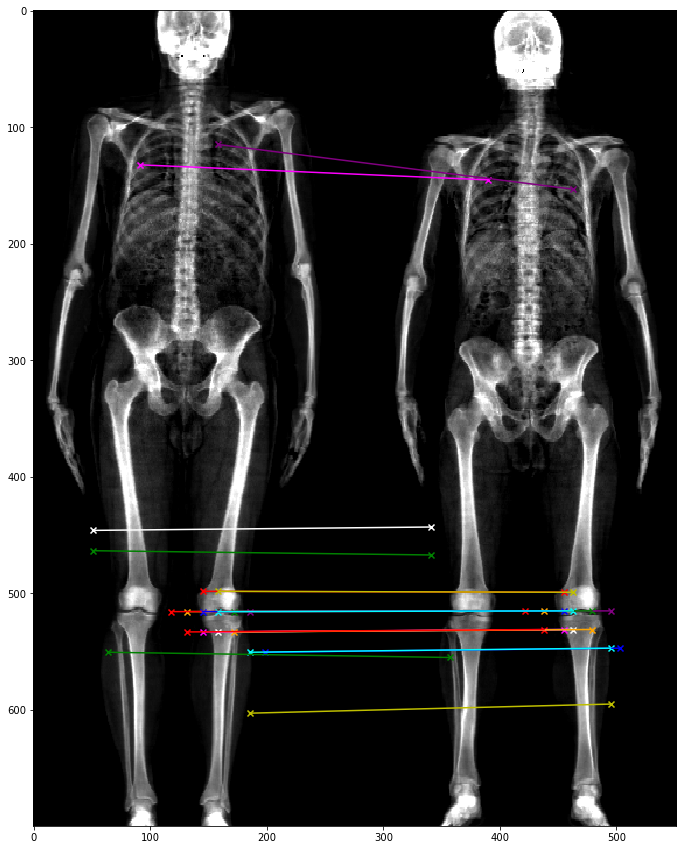

In [92]:
from gen_utils import *

src_img = dxa_img; src_ses = dxa_ses
tgt_img = dxa_img; tgt_ses = dxa_ses
src_idx = 8
tgt_idx = 2
save_file_name = f'images/keypoint_transfer/dxa_to_dxa/example_{str(src_idx).zfill(3)}_{str(tgt_idx).zfill(3)}'

corr4d = get_4d_corr(src_ses[src_idx][None], tgt_ses[tgt_idx][None])
print(src_img.shape)
# get mesh in source_image image
X,Y =np.meshgrid(np.linspace(10,src_img.shape[-2]-10,40),np.linspace(10,src_img.shape[-1]-10,20))
points = np.stack((X.reshape(-1),Y.reshape(-1))).transpose()
points = points[np.random.permutation(np.arange(points.shape[0]))]

# find most discriminative from meshgrid
src_discrim_points, tgt_match_points, correlations = get_most_discriminative_points(points,
                                                                                    corr4d[0],
                                                                                    src_img[src_idx], 
                                                                                    tgt_img[tgt_idx],num_points=300)

src_inliers, tgt_inliers,M = RANSAC(src_discrim_points, tgt_match_points, tol=5)

if src_img.shape[-2] < tgt_img.shape[-2]:
    src_pad = np.concatenate([src_img[src_idx,0], np.zeros((tgt_img.shape[-2]-src_img.shape[-2],src_img.shape[-1]))])
else: 
    src_pad = src_img[src_idx,0]
    
plt.figure(figsize=(15,15))

plt.imshow(grayscale(np.concatenate([src_pad,tgt_img[tgt_idx,0]],axis=1)))
colors=['r','g','y','b','cyan','orange','purple','white','magenta']
for idx, point in enumerate(src_inliers):
    plt.scatter(point[1],point[0],color=colors[idx%colors.__len__()],marker='x')
    match_point = tgt_inliers[idx]
    plt.scatter(match_point[1]+src_img.shape[-1],match_point[0],marker='x',color=colors[idx%colors.__len__()])
    plt.plot([match_point[1]+src_img.shape[-1],point[1]],
             [match_point[0],point[0]],color=colors[idx%colors.__len__()])

plt.savefig(save_file_name)

plt.show()


# MRI to MRI

torch.Size([10, 2, 700, 276])


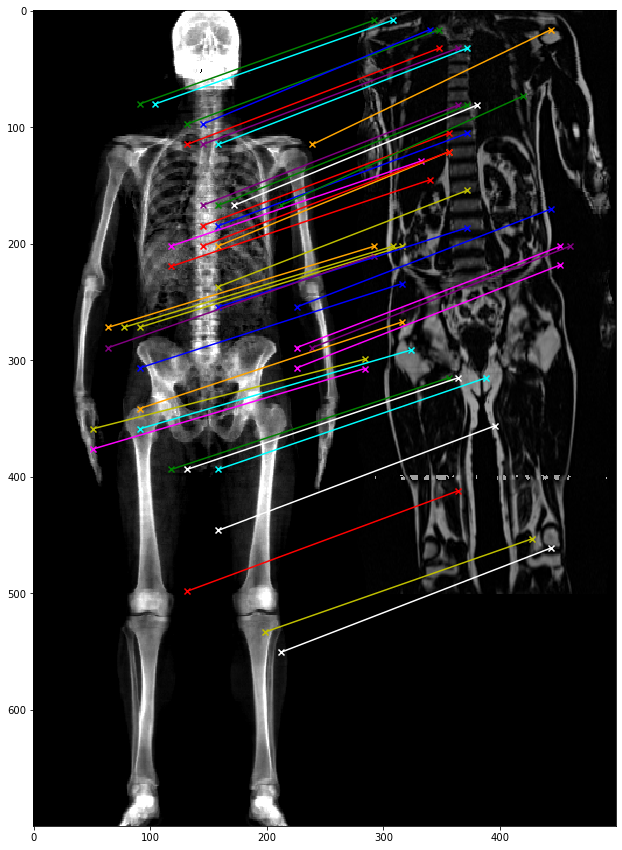

In [34]:
from gen_utils import *

src_img = dxa_img; src_ses = dxa_ses
tgt_img = mri_img; tgt_ses = mri_ses
src_idx = 2
tgt_idx = 2
TOLERANCE=15
save_file_name = f'images/keypoint_transfer/mri_to_mri/example_{str(src_idx).zfill(3)}_{str(tgt_idx).zfill(3)}'

corr4d = get_4d_corr(src_ses[src_idx][None], tgt_ses[tgt_idx][None])
print(src_img.shape)
# get mesh in source_image image
X,Y =np.meshgrid(np.linspace(10,src_img.shape[-2]-10,40),np.linspace(10,src_img.shape[-1]-10,20))
points = np.stack((X.reshape(-1),Y.reshape(-1))).transpose()
points = points[np.random.permutation(np.arange(points.shape[0]))]

# find most discriminative from meshgrid
src_discrim_points, tgt_match_points, correlations = get_most_discriminative_points(points,corr4d[0],src_img[src_idx], tgt_img[tgt_idx],num_points=300)

src_inliers, tgt_inliers, M = RANSAC(src_discrim_points, tgt_match_points, tol=TOLERANCE)

if src_img.shape[-2] < tgt_img.shape[-2]:
    src_img = np.concatenate([src_img[src_idx,0], np.zeros((tgt_img.shape[-2]-src_img.shape[-2],src_img.shape[-1]))])
    tgt_img = tgt_img[tgt_idx,0]
elif src_img.shape[-2] > tgt_img.shape[-2]:
    tgt_img = np.concatenate([tgt_img[tgt_idx,0], np.zeros((src_img.shape[-2]-tgt_img.shape[-2],tgt_img.shape[-1]))])
    src_img = src_img[src_idx,0]
plt.figure(figsize=(15,15))

plt.imshow(grayscale(np.concatenate([src_img,tgt_img],axis=1)))
colors=['r','g','y','b','cyan','orange','purple','white','magenta']
for idx, point in enumerate(src_inliers):
    plt.scatter(point[1],point[0],color=colors[idx%colors.__len__()],marker='x')
    match_point = tgt_inliers[idx]
    plt.scatter(match_point[1]+src_img.shape[-1],match_point[0],marker='x',color=colors[idx%colors.__len__()])
    plt.plot([match_point[1]+src_img.shape[-1],point[1]],
             [match_point[0],point[0]],color=colors[idx%colors.__len__()])

# plt.savefig(save_file_name)

plt.show()


torch.Size([10, 2, 700, 276])


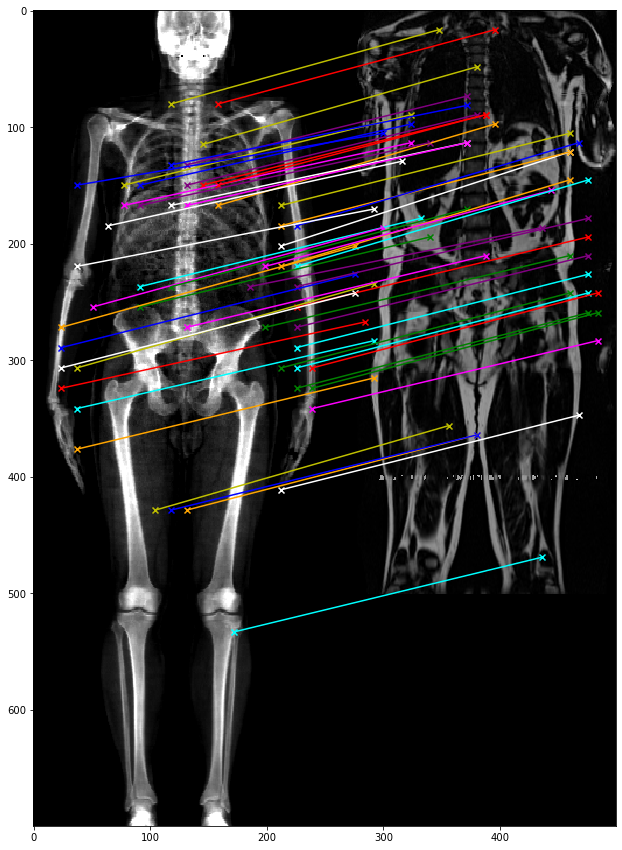

[[ 1.00444130e+00  5.87812155e-01 -2.76887072e+01]
 [-1.09260174e-02  1.39305425e+00  3.28473411e-01]
 [-1.12252786e-04  1.20199804e-03  1.00000000e+00]]


In [109]:
from gen_utils import *

src_img = dxa_img; src_ses = dxa_ses
tgt_img = mri_img; tgt_ses = mri_ses
src_idx = 8
tgt_idx = src_idx
TOLERANCE=15

corr4d = get_4d_corr(src_ses[src_idx][None], tgt_ses[tgt_idx][None])
print(src_img.shape)
# get mesh in source_image image
X,Y =np.meshgrid(np.linspace(10,src_img.shape[-2]-10,40),np.linspace(10,src_img.shape[-1]-10,20))
points = np.stack((X.reshape(-1),Y.reshape(-1))).transpose()
points = points[np.random.permutation(np.arange(points.shape[0]))]

# find most discriminative from meshgrid
src_discrim_points, tgt_match_points, correlations = get_most_discriminative_points(points,corr4d[0],src_img[src_idx], tgt_img[tgt_idx],num_points=300)

src_inliers, tgt_inliers, H = RANSAC(src_discrim_points, tgt_match_points, tol=TOLERANCE)

if src_img.shape[-2] < tgt_img.shape[-2]:
    show_src_img = np.concatenate([src_img[src_idx,0], np.zeros((tgt_img.shape[-2]-src_img.shape[-2],src_img.shape[-1]))])
    show_tgt_img = tgt_img[tgt_idx,0]
elif src_img.shape[-2] > tgt_img.shape[-2]:
    show_tgt_img = np.concatenate([tgt_img[tgt_idx,0], np.zeros((src_img.shape[-2]-tgt_img.shape[-2],tgt_img.shape[-1]))])
    show_src_img = src_img[src_idx,0]
plt.figure(figsize=(15,15))

plt.imshow(grayscale(np.concatenate([show_src_img,show_tgt_img],axis=1)))
colors=['r','g','y','b','cyan','orange','purple','white','magenta']
for idx, point in enumerate(src_inliers):
    plt.scatter(point[1],point[0],color=colors[idx%colors.__len__()],marker='x')
    match_point = tgt_inliers[idx]
    plt.scatter(match_point[1]+src_img.shape[-1],match_point[0],marker='x',color=colors[idx%colors.__len__()])
    plt.plot([match_point[1]+src_img.shape[-1],point[1]],
             [match_point[0],point[0]],color=colors[idx%colors.__len__()])

# plt.savefig(save_file_name)

plt.show()
print(M)

In [118]:
conv_map = F.conv2d(dxa_ses, mri_ses)[src_idx,tgt_idx]


torch.Size([26, 7])


AttributeError: 'numpy.ndarray' object has no attribute 't'

[64, 25]


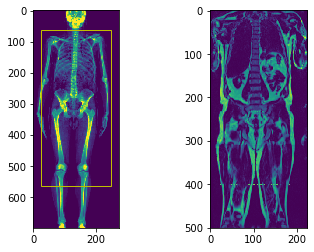

In [158]:
from matplotlib.patches import Rectangle


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[69, 29]
torch.Size([6, 501, 224]) torch.Size([10, 2, 501, 224])


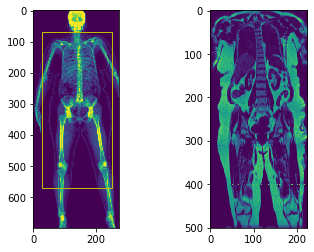

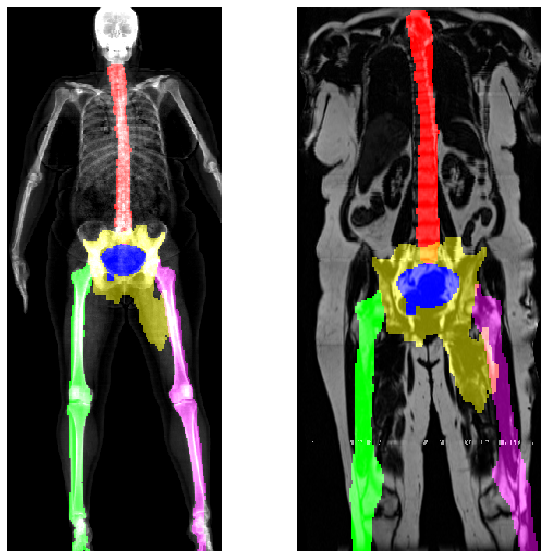

In [214]:
src_idx=9; tgt_idx=9
conv_map = F.conv2d(dxa_ses,mri_ses)[src_idx,tgt_idx]

tgt_ses_pt = [int(conv_map.argmax() // conv_map.shape[1]), int(conv_map.argmax() % conv_map.shape[1])]
plt.imshow(conv_map)
upsample_conv_map= F.interpolate(conv_map[None,None],size=(dxa_img.shape[-2]-mri_img.shape[-2],dxa_img.shape[-1]-mri_img.shape[-1]),mode='bicubic')[0,0]
plt.imshow(upsample_conv_map)
tgt_ses_pt = [int(upsample_conv_map.argmax() // upsample_conv_map.shape[-1]), int(upsample_conv_map.argmax() % upsample_conv_map.shape[-1])]

plt.scatter(tgt_ses_pt[1],tgt_ses_pt[0])

print(tgt_ses_pt)
plt.subplot(121)
plt.imshow(dxa_img[src_idx,0])

plt.gca().add_patch(Rectangle([tgt_ses_pt[1],tgt_ses_pt[0]],mri_img.shape[-1],mri_img.shape[-2],ec='y',fc='none'))
plt.subplot(122)
plt.imshow(tgt_img[tgt_idx,0])

new_segment = sample['target'][src_idx,:,
                               tgt_ses_pt[0]:tgt_ses_pt[0]+mri_img.shape[-2],
                               tgt_ses_pt[1]:tgt_ses_pt[1]+mri_img.shape[-1]]
print(new_segment.shape, mri_img.shape)
plt.figure(figsize=(10,10))

plt.subplot(121)
plt.axis('off')
plt.imshow(red(sample['target'][src_idx,1])+grayscale(dxa_img[src_idx,0])+\
           blue(sample['target'][src_idx,5])+\
           yellow(sample['target'][src_idx,2]-sample['target'][src_idx,5])+\
           green(sample['target'][src_idx,3])+\
           blue(sample['target'][src_idx,5])+\
           pink(sample['target'][src_idx,4]))
plt.subplot(122)  
plt.axis('off')
plt.imshow(red(new_segment[1])+\
           grayscale(mri_img[tgt_idx,0])+\
           blue(new_segment[5])+\
           yellow(new_segment[2]-new_segment[5])+\
           green(new_segment[3])+\
           pink(new_segment[4])
          )
plt.savefig(f'images/segmentation_transfer/transfer_{src_idx}_{tgt_idx}')